### Convolutional neural network classifier with object oriented programming

The objective for this present notebook is to train the best possible deep-learning classifiers (convolutional neural networks - CNN) from a set of 3671 flower images. The photo collection contains differently shaped images, therefore we first surveyed their aspect ratios to select the most prevalent aspect ratio and drop the least information we could. The code makes use of object oriented programming for reusability and compactness (*don't repeat yourself* principle) at creating and calling new models. This project was part of one of the machine learning courses in a data science masters degree.

We initially deploy a very simple model (*model0*), followed by one with overfitting-prevention via droput, regularization and normalization (*model1*). We also apply data augmentation and by the end of the study we use transfer learning via the VGG16 pretrained model. 


The flowers portrayed in the images fall into one of the following species: roses, dandelions, daisies, tulips and sunflowers. 


We start by loading a few libraries: numpy and pandas for array and data manipulation, matplotlib and seaborn for plotting, keras and tensorflow modules for the CNN models. 



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils

from keras.layers.core import Dense,Activation,Flatten,Dropout
from sklearn.preprocessing import normalize
#from keras.datasets import mnist
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras import backend as bk


2023-04-24 18:57:21.070491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



As a preliminary step we survey the image properties. Considering that the admission layer for the CNNs receives a fixed image resolution, we deem an image-resolution survey important in order to require the least possible trimming, which we favor ahead of aspect-ratio distortion so that the neural network learn to recognize each species proportions as they normally are.


In [ ]:
### data loading 
import os
import subprocess
from os.path import isfile, join, isdir
from os import listdir
#import cv2 ### imortamos OpenCV
from PIL import Image
import PIL
import tensorflow as tf
import pathlib
import pandas as pd


### We specify the images directory, and where the test and validation
imagespath="flower_photos/"
imagespathtest="test_flower_photos"
imagespathval="val_flower_photos"
### Pathlib objects store properties in convenient ways,
## for instance, it allows usage of the specific folder name as well as it 
## full path, wherever needed, as well as using the bash ls function (dir in Windows) with a single line.
data_dir = pathlib.Path(imagespath)
#testdata_dir= pathlib.Path(imagespathtest)
#valdata_dir= pathlib.Path(imagespathval)

data_dir.exists()
data_dir.is_dir()
for d in data_dir.iterdir():
    print(d)
    
#Contamos los archivos
image_count = len(list(data_dir.glob('*/*.jpg')))
subdirs=[f for f in listdir(imagespath) if isdir(imagespath+f)]
print("Subdirectories (and labels) : ", subdirs)
print("We have : ", image_count, "images")


roses = list(data_dir.glob('roses/*'))
rose0=PIL.Image.open(str(roses[0]))
print(rose0.size)

keyLs=["name","nx0","ny0","tupXY","aspect"]
picsizesDct={}
for key in keyLs:
    picsizesDct[key]=[]
#picsizesDct={"name":[],"nx0":[],"ny0":[],}

### Just storing some image properties in 
### dictionary form
for pic in list(data_dir.glob('*/*.jpg')):
    phot=PIL.Image.open(pic)
    picsizesDct["name"].append(pic)
    picsizesDct["nx0"].append(phot.size[0])
    picsizesDct["ny0"].append(phot.size[1])
    picsizesDct["tupXY"].append(phot.size)
    picsizesDct["aspect"].append(  phot.size[1]/phot.size[0] )
    
    
### We explore how the different image sizes are distributed
picsizesDF=pd.DataFrame(picsizesDct)
picsizesDF["nx0"].hist(color="cyan")
plt.show()
picsizesDF["ny0"].hist(color="yellow")
plt.show()
picsizesDF["aspect"].hist(color="magenta")
plt.show()
#picsizesDF["tupXY"].hist(color="magenta")
#plt.show()
print("Number of unique nx,ny combinations: ", len(set(picsizesDF["tupXY"])))
picsizesDF.info()
picsizesDF.describe()

## aspect ratio
print("The most frequent resolution is : ",picsizesDF["tupXY"].mode())
print("The most frequent aspect ratio is : ", picsizesDF["aspect"].mode() )
print("There are ",len(set(picsizesDF["aspect"])), " different aspect ratios")

##  As an example we plot the first element of each flower category 
for sd in subdirs:
    lst=[imagespath+sd+"/"+f for f in listdir(imagespath+sd) if isfile(imagespath+sd+"/"+f)]
    print(lst[0])
    phot=PIL.Image.open(lst[0])
    display(phot)


The pixel resolution distribution defines the strategy for preserving the most information. We observe 
that most frequent aspect ratio is 4:3, with 500x333 being the majority size in pixels. Therefore, we will respect the 4:3 dominant proportion and crop the non-4:3 images using the PIL library tools. Afterwards, if needed in order to increase processing speed, we may downscale the pictures while keeping their aspect ratios fixed. Upscaling is not considered, as in principle there is no information gain. 




The full set division into train/validate/test subsets is performed by the function *split_train_val_test* defined below. The option to remerge everything into the original folder can be applied via *remerge_trainvaltest*, also defined in the following block. 
The former function creates the train/validate/test folders and moves the specified proportion of files to each directory, selecting randomly. For this project we chose a 70-20-10 ratio, introduced as default in the method. 


In [ ]:

import math
import numpy as np
import os
import subprocess as sbp
from os.path import isfile, join, isdir
from os import listdir

def split_train_val_test(splitdct={"test":10.0,"val":20.0}):
  # check whether splitting is already done
  alreadyfile="alreadySPLIT.out"
  exists=os.path.isfile(alreadyfile)#.is_file():
  
  source_folder="flower_photos/"
  target_folders=["test_flower_photos/","val_flower_photos/"]

  
  split=[splitdct["test"]/100.0,(splitdct["val"]/100)/(1.0-splitdct["test"]/100)]

  if exists == 1 :
      fread=open(alreadyfile,"r")
  
      for l in fread:
          print(l)
  
      fread.close
      return "train-val-test division has already been done"
      #import sys
      #sys.exit(" 'aldeadySPLIT.out' safety file is in place, aborting ")


  #exists=os.path.isfile(alreadyfile)
  fwrite=open(alreadyfile,"w")
  sourceSubdirs=[f for f in listdir(source_folder) if isdir(join(source_folder, f))]
  for itar,target_folder in enumerate(target_folders):
  	cmdstr="mkdir "+target_folder
  	sbp.call(cmdstr,shell=True)

  	for sd in sourceSubdirs:
  		pass
  		folder=source_folder+sd+"/"
  		fileLs=[f for f in listdir(folder) if isfile(join(folder, f))]
  		nF=len(fileLs)
  		ranvec=np.random.randint(0,high=nF,size=int(nF*split[itar]),dtype=int)
  
  
  		cmdstr="mkdir "+target_folder+sd
  		sbp.call(cmdstr,shell=True)
  		for ifile,fil in enumerate(fileLs):
  			if ifile in ranvec:
  				cmdstr="mv "+folder+fil+" "+target_folder+sd+"/."
  				print(cmdstr)#
  				fwrite.write( cmdstr+"\n" )
  				sbp.call(cmdstr,shell=True)
  
  	#for sd in sourceSubdirs:
  	#    fwrite.write( sd )
  fwrite.close()



def remerge_trainvaltest():
    
  alreadyfile="alreadySPLIT.out"
  exists=os.path.isfile(alreadyfile)#.is_file():
  
  target_folders=["flower_photos/"]
  source_folders=["test_flower_photos/","val_flower_photos/"]
  
  if exists:
    sbp.call("rm "+alreadyfile, shell=True)
  
  for itar,target_folder in enumerate(target_folders):
    #cmdstr="mkdir "+target_folder
    #sbp.call(cmdstr,shell=True)
    for sfold in source_folders:
  
      sourceSubdirs=[f for f in listdir(sfold) if isdir(join(sfold, f))]
      for sd in sourceSubdirs:
          
        folder=sfold+sd+"/"
        fileLs=[f for f in listdir(folder) if isfile(join(folder, f))]
        nF=len(fileLs)
        #ranvec=np.random.randint(0,high=nF,size=int(nF*split[itar]),dtype=int)
  
  
        cmdstr="mkdir "+target_folder+sd
        sbp.call(cmdstr,shell=True)
        for ifile,fil in enumerate(fileLs):
          #if ifile in ranvec:
          cmdstr="mv "+folder+fil+" "+target_folder+sd+"/."
          print(cmdstr)#
          #fwrite.write( cmdstr+"\n" )
          sbp.call(cmdstr,shell=True)

In [4]:
split_train_val_test()

#remerge_trainvaltest()

mv flower_photos/roses/2325232198_751645d0bb_n.jpg test_flower_photos/roses/.

mv flower_photos/roses/6280787884_141cd7b382_n.jpg test_flower_photos/roses/.

mv flower_photos/roses/6163179241_f093f45d95_n.jpg test_flower_photos/roses/.

mv flower_photos/roses/14312910041_b747240d56_n.jpg test_flower_photos/roses/.

mv flower_photos/roses/15174615529_144ae28bdb_n.jpg test_flower_photos/roses/.

mv flower_photos/roses/6039330368_c30ed224c4_m.jpg test_flower_photos/roses/.

mv flower_photos/roses/12406418663_af20dc225f_n.jpg test_flower_photos/roses/.

mv flower_photos/roses/6158504080_b844a9ae05.jpg test_flower_photos/roses/.

mv flower_photos/roses/3713368809_eba7fa2fbf_m.jpg test_flower_photos/roses/.

mv flower_photos/roses/16552686350_db8db55cd2.jpg test_flower_photos/roses/.

mv flower_photos/roses/15060816740_68e1b2c31b.jpg test_flower_photos/roses/.

mv flower_photos/roses/2550860627_998a4fc4c1.jpg test_flower_photos/roses/.

mv flower_photos/roses/8590442797_07fa2141c0_n.jpg test

'train-val-test division has already been done'

Below we define the PhotoSet and Gallery classes.
A Gallery object is instantiated by supplying the three directories train/validate/test. Once a Gallery object is created it internally instantiates three PhotoSet objects. The PhotoSet class deals with the image manipulation, reading, resizing, data augmentation, order randomization and PIL crop verification (checks whether PIL has created a black image if the supplied cropped size is larger than the original image).
The data augmentation is performed using the ImageDataGenerator class from the Keras Preprocessing module.

In [ ]:




#import keras.utils as keru
#from keras import utils as keru

from PIL import Image
from keras.utils import np_utils
import copy
import random
from keras.preprocessing.image import ImageDataGenerator

class PhotoSet():
    """
    -dire : the directory from which to read the photos
    -sizetuple : a tuple with the image sizes after downscaling
    -crop_to_aspect_ratio: (default true) will select the largest subimage possible
    if having to crop to different 
    -shuffle: (default true) whether to randomly change the photo ordering 
    -augment : (default None) an integer factor to wh*ich augment the size of the set
    -greyscale : (default False, NOT IMPLEMENTED) The idea was to replace the RGB channels by just one
       and test whether the performance gain (just one channel) justified some information loss"""
    def __init__(self, dire,sizetuple,greyscale=False,crop_to_aspect_ratio=True,shuffle=True,augment=None):
        fileLs=[f for f in listdir(dire) if isfile(join(dire, f))]
        
        self.sizetuple=sizetuple
        self.aspect=sizetuple[1]/sizetuple[0]
        self.dire=dire
        self.shuffle=shuffle
        self.augment=augment
                   
        if augment is None:
            self.read_photos_from_dir()
        else :
            self.NAug=augment
            self.read_photos_from_dir_augment()
        self.allblacks_check()
       
        if self.shuffle==True:
            self.shufflePics()
            
        self.ArrayLs=np.asarray(self.ArrayLs,dtype="float32")/255
        self.ILabelFullLs=np_utils.to_categorical(np.asarray(self.ILabelFullLs))#np_utils.to_categorical(self.ILabelFullLs)
        #self.big_reshape() # prpara los arrays
    def shufflePics(self):
        ### ArrayLs
        
        iorder=list(np.arange(self.NPics))
        random.shuffle(iorder)
        self.scrambled=iorder
        Arr0=copy.deepcopy(self.ArrayLs)
        Ls0=copy.deepcopy(self.ILabelFullLs)
        
        self.ArrayLs=[]
        self.ILabelFullLs=[]
        for ifile in self.scrambled:
            self.ArrayLs.append(Arr0[ifile])
            self.ILabelFullLs.append(Ls0[ifile])
    ### control de que un crop de PIL mal hecho no entregue una 
    ### figura totalmente negra
    def allblacks_check(self):
        ichan=0
        #pxcheck=[0.0,0.25,0.5,0.75,0.95]
        #ncheck=len(pxcheck)
        
        AllBlackLs=[]
        for ipic, picArr in enumerate(self.ArrayLs):
            #nx,ny,nchan=np.shape(picArr)
            #compLs=[]
            #comp=np.zeros(ncheck,dtype=int)
            #for icheck,fact in enumerate(pxcheck):
            #    ix=int(np.floor(fact*nx))
            #    iy=int(np.floor(fact*ny))
            #    comp[icheck]=picArr[ix,iy,ichan]
            overallmax=np.amax(picArr)
            #uniq=set(comp)
            #if len(uniq)==1:
            if overallmax == 0:
                AllBlackLs.append(ipic)
                if self.augment==None:
                    display(self.PhotLs[ipic])
        ### Simple direct check, if the overall maximum is zero
        ### it means the image is plain black.
        if len(AllBlackLs)==0:
            print("No full black images from improper PIL crop")
        else :
            
            print("Check whether some images were improperly cut by PIL")
    def read_photos_from_dir(self):    
        self.subdirs=[f for f in listdir(self.dire) if isdir(join(self.dire, f))]
        self.LabelsShort=subdirs
        
        print(self.dire,self.subdirs)
        self.LabelFullLs=[]
        self.ILabelFullLs=[]
        self.PhotLs=[]
        self.PhotCheckLs=[]
        self.ArrayLs=[]
        self.NPics=0
        for isd,sd in enumerate(self.subdirs):        
            folder=self.dire+"/"+sd+"/"
            fileLs=[folder+f for f in listdir(folder) if isfile(join(folder, f))]
            print(len(fileLs))
            for ifil, fil in enumerate(fileLs):
                self.LabelFullLs.append(sd)
                self.ILabelFullLs.append(isd)
                #print(fil)
                phot=PIL.Image.open(fil)
                nx0,ny0=phot.size
                asp0=ny0/nx0
                
                (nx1,ny1)=self.undistorted_largest(asp0,nx0,ny0)
                #print( nx0,ny0,nx1,ny1)
                phot = phot.crop((0,0,nx1-1, ny1-1))
                if (nx1-1>nx0):
                    print("Warning, nx1-1>nx0")
                if (ny1-1>ny0):
                    print("Warning, nx1-1>nx0")

                phot = phot.resize(self.sizetuple)
                #print("Final size", phot.size)
                self.PhotLs.append(phot)
                
                phot1=np.asarray(phot,order="C")
                #shape0=np.shape(phot1)
                #phot1=np.swapaxes(phot1,0,2)
                #shape1=np.shape(phot1)
                #phot=np.swapaxes(phot1,1,2)
                ##shape2=np.shape(phot1)
                ##print(shape0,shape1)#,shape2)
                self.ArrayLs.append(phot1)
                #self.PhotCheckLs.append(Image.fromarray(phot1[0])) 
                self.PhotCheckLs.append(Image.fromarray(phot1[:,:,0])) 
                ##phot= im.crop((left, top, right, bottom))
                self.NPics+=1
    def read_photos_from_dir_augment(self):    
        ## same as above, only it instantiates ImageDataGenerator and
        self.subdirs=[f for f in listdir(self.dire) if isdir(join(self.dire, f))]
        self.LabelsShort=subdirs
        
        print(self.dire,self.subdirs)
        self.LabelFullLs=[]
        self.ILabelFullLs=[]
        self.PhotLs=[]
        self.PhotCheckLs=[]
        self.ArrayLs=[]
        self.NPics=0
        for isd,sd in enumerate(self.subdirs):        
            folder=self.dire+"/"+sd+"/"
            fileLs=[folder+f for f in listdir(folder) if isfile(join(folder, f))]
            print("Pre augmentation: "+str(len(fileLs)) )    
            for ifil, fil in enumerate(fileLs):

                #print(fil)
                phot=PIL.Image.open(fil)
                nx0,ny0=phot.size
                asp0=ny0/nx0
                
                (nx1,ny1)=self.undistorted_largest(asp0,nx0,ny0)
                #print( nx0,ny0,nx1,ny1)
                phot = phot.crop((0,0,nx1-1, ny1-1))
                if (nx1-1>nx0):
                    print("Warning, nx1-1>nx0")
                if (ny1-1>ny0):
                    print("Warning, nx1-1>nx0")

                phot = phot.resize(self.sizetuple)
                #print("Final size", phot.size)
                self.PhotLs.append(phot)
                
                phot1=np.asarray(phot,order="C")
                ######################################
                ### La augmentation puede operar a partir del array de la imagen
                ### Aplicamos aug y agregamos a la pila
                samples = np.expand_dims(phot1, 0)
                AugGen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                                  height_shift_range=0.1,  
                                  zoom_range=0.2, horizontal_flip=True)
                itera=AugGen.flow(samples, batch_size=1)
                for igen in range(self.NAug):
                    self.LabelFullLs.append(sd)
                    self.ILabelFullLs.append(isd)
                    AugBatch=itera.next()
                    #print("AugBatch",AugBatch)
                    #print(np.shape(AugBatch))
                    self.ArrayLs.append(AugBatch[0])
                    
                    ##self.PhotCheckLs.append(Image.fromarray(phot1[0])) 
                    self.PhotCheckLs.append(Image.fromarray(AugBatch[0,:,:,0])) 
                    
                    self.NPics+=1

                
            
                ######################################
                

    def undistorted_largest(self,asp0,nx0,ny0):
        ## picks the largest original image size that can be read while respecting 
        ## the aspect ratio calculated from sizetuple. 
        if nx0==self.sizetuple[0] and ny0==self.sizetuple[1]:
            
            nx1=nx0
            ny1=ny0
        elif asp0 == self.aspect:
            nx1=max(nx0,self.sizetuple[0])
            ny1=max(ny0,self.sizetuple[1])
        elif  asp0 < self.aspect: ## original is wider 
            
            ny1=ny0
            nx1=int(ny1/self.aspect)
        elif  asp0 > self.aspect : ## original is taller
            pass
            nx1=nx0
            ny1=int(nx1*self.aspect)
        
        newsize=(nx1,ny1)
        return newsize

                
        #
### y , o sea , self labels y_test=np_utils.to_categorical(y_test)
    def get_nxf_nyf(self,newasp,nx0,ny0):
        pass
class Gallery():
    #geenralizar a formatLs
    def __init__(self,name,direTrain,direVal,direTest,sizetuple,greyscale=False,crop_to_aspect_ratio=True,augment=None):
        
        #gets the imagefiles in the folder
        #self.batch_size=batch_size
        self.name=name
        self.direTrain=direTrain
        self.direVal=direVal
        self.direTest=direTest
        self.sizetuple=sizetuple
        self.crop_to_aspect_ratio=crop_to_aspect_ratio
        self.augment=augment
        self.Train=PhotoSet(self.direTrain,self.sizetuple,augment=self.augment)
        self.Val=PhotoSet(self.direVal,self.sizetuple,augment=self.augment)
        self.Test=PhotoSet(self.direTest,self.sizetuple,augment=self.augment)
        
    
        
        
        


We start creating the galleries. Augmentation of PhotoSet objects is performed *on the fly*, as in *no new files are created*. The transformed images are generated after reading each original file. The example below augments the set by a factor 7. 

Beware, the RAM usage will escalate significantly. If you have less than 32GB do not instantiate GalleryAug in the next block. 

In [6]:
GalleryAug=Gallery("galleryAug",imagespath,imagespathval,imagespathtest,sizetuple=(160,120),crop_to_aspect_ratio=True,augment=7)


flower_photos/ ['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']
Pre augmentation: 463
Pre augmentation: 454
Pre augmentation: 655
Pre augmentation: 582
Pre augmentation: 507
No full black images from improper PIL crop
val_flower_photos ['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']
Pre augmentation: 116
Pre augmentation: 118
Pre augmentation: 161
Pre augmentation: 143
Pre augmentation: 127
No full black images from improper PIL crop
test_flower_photos ['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']
Pre augmentation: 62
Pre augmentation: 61
Pre augmentation: 82
Pre augmentation: 74
Pre augmentation: 65
No full black images from improper PIL crop


We create a list with two non-augmented galleries, to which we will apply the deep learning models that we define below. Both are based on the 4:3 aspect ratio: GallerySmall's image size is 160x120 while for GalleryMid it is 240x180.


In [ ]:
        
        
GallerySmall=Gallery("gallerySmall",imagespath,imagespathval,imagespathtest,sizetuple=(160,120),\
                     crop_to_aspect_ratio=True)
#print(GallerySmall.Test.LabelFullLs[-5:-1])
GalleryMid=Gallery("galleryMid",imagespath,imagespathval,imagespathtest,sizetuple=(240,180),\
                   crop_to_aspect_ratio=True)

#GalleryBig=

GalleryLs=[GallerySmall,GalleryMid]

We display, just for consistency, a few GallerySmall samples, with a 160x120 resolution.

In [ ]:
## samples:
display(GallerySmall.Train.PhotLs[0])
display(GallerySmall.Train.PhotCheckLs[0])
display(GallerySmall.Val.PhotLs[0])
display(GallerySmall.Test.PhotLs[0])

display(GallerySmall.Train.PhotLs[-1])
display(GallerySmall.Val.PhotLs[-1])
display(GallerySmall.Test.PhotLs[-1])

#GallerySmall.ImgTrain._structure[0]

print(type(GallerySmall.Train.ArrayLs))
print(np.shape(GallerySmall.Train.ArrayLs))
print(type(GallerySmall.Train.ILabelFullLs))
print(np.shape(GallerySmall.Train.ILabelFullLs))


In order to systematize the models application to the different data sets we create the SequentialModelz class, which is instanced by the specific model name (e.g., *model0*, *model1*) and a Galery class object.
SequentialModelz is named after the Sequential Keras API which is used to define the convolutional, pooling and other type of layers. The clase also incorporates graphcal performance evaluation, such as the accuracy. training history and confusion matrices. 

The input layers accepts arrays with dimensions *nx*x*ny* times the number of channels *nchan*, corresponding to each image pixel. The output channel has the same number of neurons as the possible classification labels from the Gallery object, i.e., the five flower species considered in this example.

We define a simple model (*model0*) which we follow with a more comprehensive one that includes anti-overfitting measures, namely dropout, normalization and regularization.


In [9]:
## We define the model class structure

from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,BatchNormalization,LayerNormalization

class SequentialModelz():
    def __init__(self,GalleryObj,modelname,nfiltLs,nbinsLs,npoolLs,\
                 batchsize=20,epochs=15):
    
        self.model = Sequential() ## inicializamos un objeto de la clase Sequential
        assert(isinstance(GalleryObj,Gallery)) ### check de que se trate de un objeto de la clase Gallery.
        self.GalleryObj=GalleryObj
        self.nphot,self.nx,self.ny,self.nchan=np.shape(GalleryObj.Train.ArrayLs)    
        self.ncols=np.shape(GalleryObj.Train.ILabelFullLs)[1]
        self.modelname=modelname
        self.nfiltLs=nfiltLs
        self.nbinsLs=nbinsLs
        self.npoolLs=npoolLs
        self.batchsize=batchsize
        self.epochs=epochs
        #self.
        
    def setup_model0(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## input layer
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
                              input_shape=(self.nx, self.ny, self.nchan),activation='relu'))
        self.model.add(MaxPool2D(pool_size=(self.npoolLs[0],self.npoolLs[0])))
        ## intermediate layers
        for inb,nb in enumerate(self.nbinsLs[1:],1):
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb),activation='relu'))
            self.model.add(MaxPool2D(pool_size=(self.npoolLs[inb],self.npoolLs[inb])))
        ## flattening 
        self.model.add(Flatten())
        self.model.add(Dense( min(self.nx,self.ny),activation='relu'))
        self.model.add(Dense(self.ncols,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        

        #model0.summary()
        #print(history0.history.keys())
        #return model0,history0
    def setup_model1(self):
        
        ## input layer
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
                input_shape=(self.nx, self.ny, self.nchan),activation='relu'))
        self.model.add(MaxPool2D(pool_size=(self.npoolLs[0],self.npoolLs[0])))
        ## intermediate layers
        for inb,nb in enumerate(self.nbinsLs[1:],1):
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb),activation='relu'))
            ## Normalizamos
            self.model.add(BatchNormalization()) ### luego de la capa convo, aplicamos normie.
            self.model.add(MaxPool2D(pool_size=(self.npoolLs[inb],self.npoolLs[inb])))
                 
        ## Dropout, 10%
        self.model.add(Dropout(0.10))
        ## Flattening
        self.model.add(Flatten())
        ### Regularization
        self.model.add(Dense( min(self.nx,self.ny),activation='relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
        self.model.add(Dense(self.ncols,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    def run_model(self):
        self.history=self.model.fit(self.GalleryObj.Train.ArrayLs, self.GalleryObj.Train.ILabelFullLs,
              batch_size=self.batchsize,
              epochs=self.epochs,
              validation_data=(self.GalleryObj.Val.ArrayLs, self.GalleryObj.Val.ILabelFullLs))

        #model0.summary()
        #print(self.history.history.keys())
        #return model0,history0
        
    def plot_history(self):
        histDF=pd.DataFrame(self.history.history)
        histDF["epoch"]=self.history.epoch

        plt.figure()
        plt.xlabel("Epoch")
        plt.ylabel("Loss function" )
        plt.plot(histDF["epoch"],histDF["loss"],"r--",label="Training Loss")
        plt.plot(histDF["epoch"],histDF["val_loss"],"b-.",label="Validation Loss")

        #plt.ylim([0,0.5])
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.show()
        plt.savefig("Ej2_Loss_"+self.model.name+"_"+\
                    self.GalleryObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        plt.figure()
        plt.xlabel("Epoch")
        plt.ylabel("Loss function" )
        plt.plot(histDF["epoch"],histDF["accuracy"],"r--",label="Training Acc.")
        plt.plot(histDF["epoch"],histDF["val_accuracy"],"b-.",label="Validation Acc.")

        #plt.ylim([0,0.5])
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.show()
        plt.savefig("Ej2_Acc_"+self.model.name+"_"+\
                    self.GalleryObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        
    def predict(self):
        # the category index with the largest rating
         self.pred= np.argmax(self.model.predict(self.GalleryObj.Test.ArrayLs),axis=-1)

    def make_confusion_mat(self,TestTrue):
        pass
        
        self.confmat=pd.crosstab(self.pred,TestTrue  )
        truetrue=np.sum(np.diagonal(self.confmat.to_numpy() ))
        accu=truetrue/np.sum(self.confmat.to_numpy() )
        print("Test Accuracy :", accu)
        
        self.TestTrue=TestTrue
        
        fig = plt.figure(figsize=(8.0, 8.0), dpi=80)
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        res = sn.heatmap(self.confmat, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

        plt.savefig("Ej2_confmat_"+self.modelname+"_"+self.GalleryObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        plt.show()
        
        


In the following block we will make use of the SequentialModelz class to carry out four studies, each producing their corresponding performance graphs. Specifically, the four cases are the crossover between the sets {*model0*,*model1*} and {GallerySmall,GalleryMid}. The galleries have image sizes of 160x120 and 240x180 respectively. 

The application of *model1* aims to reduce overfitting and improve the testing accuracy, whereas the comparison between the two gallery results is directed towards evaluating to what extent the image resolution plays a role in subject recognition. 

A basic starting hypothesis is that accuracy should drop as a trade-off to the speedup for working with smaller arrays. We will also test whether lower resolution prevents overfitting, characterized by significantly better validation- than testing-accuracies, i.e., meaning the model has attached a level of detail higher than the category true scope.  


In [18]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#tf.Session(config=config)

#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
###  loopeamos sobre los objetos de la clase Gallery.
ModelNamesLs=["model0","model1"]
ModelsLs=[]
for iGal, Gal in enumerate(GalleryLs):
    for Mo in ModelNamesLs:
        ModObj=SequentialModelz(Gal,Mo,[16,12],[3,3],[2,2],batchsize=20,epochs=15)
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Gal.Test.ILabelFullLs,axis=-1))
        #pred = model.predict_classes(Gal.Test.ArrayLs)
    #pred = model0.predict_classes(GallerySmall.Val.ILabelFullLs)
        #ModObj.predict()
        #ModObj.TestTrue=np.argmax(Gal.Test.ILabelFullLs,axis=-1)
        #print(np.shape(pred))
        #te=np.argmax(Gal.Test.ILabelFullLs,axis=-1)







Epoch 1/15
134/134 [==============================] - 7s 49ms/step - loss: 1.3866 - accuracy: 0.4130 - val_loss: 1.1907 - val_accuracy: 0.4902
Epoch 2/15
134/134 [==============================] - 6s 46ms/step - loss: 1.0702 - accuracy: 0.5637 - val_loss: 1.1621 - val_accuracy: 0.5188
Epoch 3/15
134/134 [==============================] - 6s 45ms/step - loss: 0.9066 - accuracy: 0.6546 - val_loss: 1.1708 - val_accuracy: 0.5579
Epoch 4/15
134/134 [==============================] - 6s 48ms/step - loss: 0.6707 - accuracy: 0.7557 - val_loss: 1.0533 - val_accuracy: 0.5639
Epoch 5/15
134/134 [==============================] - 6s 48ms/step - loss: 0.4364 - accuracy: 0.8486 - val_loss: 1.2468 - val_accuracy: 0.5489
Epoch 6/15
134/134 [==============================] - 6s 46ms/step - loss: 0.3191 - accuracy: 0.8933 - val_loss: 1.4603 - val_accuracy: 0.5489
Epoch 7/15
134/134 [==============================] - 6s 46ms/step - loss: 0.1708 - accuracy: 0.9523 - val_loss: 1.6906 - val_accuracy: 0.5549

With both galleries, we can see that the simple model *model0* produces overfitting. This may be because the set of photos is not extensive enough to lead to a degree of generalization capable of capturing the characteristics of each species of flower, discarding elements such as those that may appear in the background, or whether it is a single or a group of flowers.

The GalleryMid set, at 240x180, produces faster learning, as observed in the history curve; convergence in training accuracy is achieved in four epochs instead of eight. The testing accuracy goes from 0.55 to 0.61 when using images from GalleryMid.

With *model1*, accuracies remain at 0.60 and 0.58, being slightly worse in the case of higher resolution images, but this variability is within the range of fluctuation obtained during training. This model spoils the learning curve to match the validation curve, rather than improving the latter, which would be desirable.

Next, still maintaining the class structure, we apply *model0* on the GalleryAug dataset (resolution 160x120) with data augmentation (sevenfold) to see if it can improve the accuracy while reducing overfitting on its own.


Epoch 1/15
932/932 [==============================] - 38s 41ms/step - loss: 1.0737 - accuracy: 0.5697 - val_loss: 0.9282 - val_accuracy: 0.6350
Epoch 2/15
932/932 [==============================] - 38s 40ms/step - loss: 0.7681 - accuracy: 0.7099 - val_loss: 0.9049 - val_accuracy: 0.6604
Epoch 3/15
932/932 [==============================] - 38s 41ms/step - loss: 0.5761 - accuracy: 0.7803 - val_loss: 0.9462 - val_accuracy: 0.6655
Epoch 4/15
932/932 [==============================] - 37s 40ms/step - loss: 0.3861 - accuracy: 0.8568 - val_loss: 1.1517 - val_accuracy: 0.6464
Epoch 5/15
932/932 [==============================] - 37s 40ms/step - loss: 0.2367 - accuracy: 0.9174 - val_loss: 1.2217 - val_accuracy: 0.6423
Epoch 6/15
932/932 [==============================] - 38s 41ms/step - loss: 0.1331 - accuracy: 0.9568 - val_loss: 1.6549 - val_accuracy: 0.6520
Epoch 7/15
932/932 [==============================] - 38s 41ms/step - loss: 0.0864 - accuracy: 0.9733 - val_loss: 1.8746 - val_accuracy:

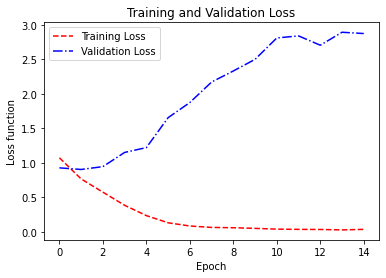

<Figure size 432x288 with 0 Axes>

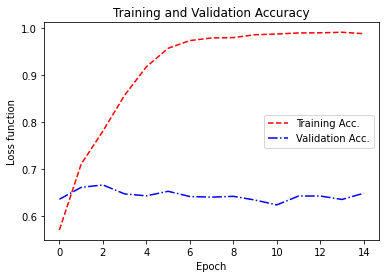

Test Accuracy : 0.6806478405315615


<Figure size 432x288 with 0 Axes>

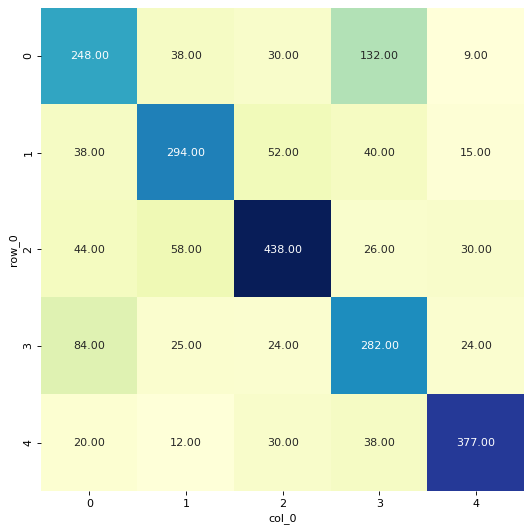

In [12]:
### We apply the simplest model to the Augmented dataset
###  we loop over the objects in the Gallery.
ModelNamesLs=["model0"]
ModelsLs=[]
for iGal, Gal in enumerate([GalleryAug]):
    for Mo in ModelNamesLs:
        ModObj=SequentialModelz(Gal,Mo,[16,12],[3,3],[2,2],batchsize=20,epochs=15)
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Gal.Test.ILabelFullLs,axis=-1))

Data augmentation with a factor of 7 of the total images achieves a significantly better classification under the same model, reaching a test accuracy of 0.68. Overfitting remains present, however. The gain of about 0.05 in accuracy came at a cost of a factor of 7 in computing time. Problems of this size can be addressed on a powerful laptop or desktop, but as the sets of images become not just thousands of elements deep, but hundreds of thousands, computational resources and time can start escalating beyond individual-user-level hardware. However, once a model is trained, it can be capitalized on multiple occasions without incurring the same cost.

This last point brings up the concept and use of pre-trained models, which involves adopting a model whose parameters have already been trained on a very large set of images, and its layer structure has proven to be effective. The pre-trained parameters have to be loaded, and subsequently the end user has the freedom to retrain some of the convolutional layers, while they can introduce dense layers relevant to their problem of interest. Relaxing the constraint of keeping the convolutional layer parameters intact intact is called fine-tuning.



### Pretrained models

In this section we use transfer learning concepts, benefiting from models that have been trained using millions of images using far more computational resources than available for the present project. We create instantiate gallery with the same resolution as GallerySmall.

In [13]:
GalleryPretrained=Gallery("galleryPretrained",imagespath,imagespathval,imagespathtest,sizetuple=(160,120),crop_to_aspect_ratio=True)


flower_photos/ ['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']
463
454
655
582
507
No full black images from improper PIL crop
val_flower_photos ['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']
116
118
161
143
127
No full black images from improper PIL crop
test_flower_photos ['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']
62
61
82
74
65
No full black images from improper PIL crop


We temporarily create a pre-trained VGG16 model to observe its layer structure.

In [14]:
from tensorflow.keras.applications import VGG16, VGG19

vgg16pre = VGG16(input_shape = (160, 120, 3),\
include_top = False, weights = 'imagenet')
vgg16pre.summary()
for layer in vgg16pre.layers:
    layer.trainable = False

vgg16pre.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 30, 128)       0     

We observe that the structure contains two blocks of two convolutional layers followed by a pooling layer, and then three blocks of three convolutions and a pooling layer.

With the same goals of organization, maintenance, and reusability of code, we created a class that contains methods to perform every task, from training to prediction and testing of a pre-trained base model, giving the option for fine-tuning through the added *FineTuning* variable. Its value is not set by default but it can be an integer indicating how many convolutional layers should be retrained.

We are using the *Functional* API of Keras, which is more general than *Sequential*. The *Functional* API syntax is evidenced by the way of adding layers to the model in the *add_final_layers* and *compile_model* functions.

In [15]:
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.applications import VGG16, VGG19
class PreatrainedModelz():
    def __init__(self,GalleryObj,modelname,\
                 batchsize=20,epochs=15,FineTune=None):
        
        #self.model = ModelObj 
        self.modelname=modelname
        assert(isinstance(GalleryObj,Gallery)) ### check whether it is a Gallery class object.
        self.GalleryObj=GalleryObj
        self.nphot,self.nx,self.ny,self.nchan=np.shape(GalleryObj.Train.ArrayLs)    
        self.ncols=np.shape(GalleryObj.Train.ILabelFullLs)[1]
        
        self.FineTune=FineTune
        self.batchsize=batchsize
        self.epochs=epochs
        
    def makebase_vgg16(self):
    
        self.trainedmodel=VGG16(input_shape = (self.nx, self.ny, self.nchan),\
            include_top = False, weights = 'imagenet')
        
    def configure_finetune(self):
        if self.FineTune is not None:
            for layer in self.trainedmodel.layers[:-self.FineTune]: 
                ### i.e., the last FineTune layers 
                layer.trainable = False
        else:
            for layer in self.trainedmodel.layers:
                layer.trainable = False

    def add_final_layers(self):
        ### The output layer takes the column no. from the OneHot labels (to_categorical), ncols.      
        self.newtop=self.trainedmodel.output
        self.newtop=Flatten()(self.newtop)
        self.newtop=Dense( min(self.nx,self.ny),activation='relu')(self.newtop)
        #self.newtop=Dense( min(self.nx,self.ny)//2,activation='sigmoid')(self.newtop)
        self.newtop=Dropout(0.10)(self.newtop)   

        self.output_layer=Dense(self.ncols,activation='softmax')(self.newtop)
        
    def compile_model(self):
        self.model = Model(inputs=self.trainedmodel.input, outputs=self.output_layer)
        self.model.compile(loss='categorical_crossentropy',optimizer='adam',\
                           metrics=['accuracy'])

    def train_model(self):
        self.history=self.model.fit(x=self.GalleryObj.Train.ArrayLs,\
                    y=self.GalleryObj.Train.ILabelFullLs,
              batch_size=self.batchsize,
              epochs=self.epochs,
              validation_data=(self.GalleryObj.Val.ArrayLs, self.GalleryObj.Val.ILabelFullLs))
        
    def plot_history(self):
        histDF=pd.DataFrame(self.history.history)
        histDF["epoch"]=self.history.epoch

        plt.figure()
        plt.xlabel("Epoch")
        plt.ylabel("Loss function" )
        plt.plot(histDF["epoch"],histDF["loss"],"r--",label="Training Loss")
        plt.plot(histDF["epoch"],histDF["val_loss"],"b-.",label="Validation Loss")

        #plt.ylim([0,0.5])
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.show()
        plt.savefig("Ej2_Loss_"+self.model.name+"_"+\
                    self.GalleryObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        plt.figure()
        plt.xlabel("Epoch")
        plt.ylabel("Loss function" )
        plt.plot(histDF["epoch"],histDF["accuracy"],"r--",label="Training Acc.")
        plt.plot(histDF["epoch"],histDF["val_accuracy"],"b-.",label="Validation Acc.")

        #plt.ylim([0,0.5])
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.show()
        plt.savefig("Ej2_Acc_"+self.model.name+"_"+\
                    self.GalleryObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        
    def predict(self):
         self.pred= np.argmax(self.model.predict(self.GalleryObj.Test.ArrayLs),axis=-1)

    def make_confusion_mat(self,TestTrue):
        pass
        
        self.confmat=pd.crosstab(self.pred,TestTrue  )
        truetrue=np.sum(np.diagonal(self.confmat.to_numpy() ))
        accu=truetrue/np.sum(self.confmat.to_numpy() )
        print("Test Accuracy :", accu)
        
        self.TestTrue=TestTrue
        
        fig = plt.figure(figsize=(8.0, 8.0), dpi=80)
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        res = sn.heatmap(self.confmat, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)

        plt.savefig("Ej2_confmat_"+self.modelname+"_"+self.GalleryObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        plt.show()
        
        

We now execute the pretrained model with zero and one retrainable layers.

Epoch 1/15
134/134 [==============================] - 64s 475ms/step - loss: 0.9101 - accuracy: 0.6652 - val_loss: 0.7316 - val_accuracy: 0.7383
Epoch 2/15
134/134 [==============================] - 63s 467ms/step - loss: 0.5105 - accuracy: 0.8238 - val_loss: 0.7196 - val_accuracy: 0.7564
Epoch 3/15
134/134 [==============================] - 62s 466ms/step - loss: 0.3428 - accuracy: 0.8794 - val_loss: 0.7185 - val_accuracy: 0.7444
Epoch 4/15
134/134 [==============================] - 63s 471ms/step - loss: 0.2350 - accuracy: 0.9241 - val_loss: 0.7121 - val_accuracy: 0.7850
Epoch 5/15
134/134 [==============================] - 63s 470ms/step - loss: 0.1749 - accuracy: 0.9433 - val_loss: 0.6759 - val_accuracy: 0.7910
Epoch 6/15
134/134 [==============================] - 63s 467ms/step - loss: 0.1060 - accuracy: 0.9692 - val_loss: 0.7047 - val_accuracy: 0.7835
Epoch 7/15
134/134 [==============================] - 63s 468ms/step - loss: 0.1065 - accuracy: 0.9718 - val_loss: 0.7473 - val_ac

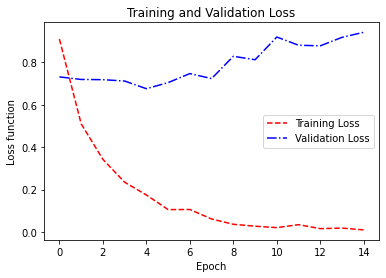

<Figure size 432x288 with 0 Axes>

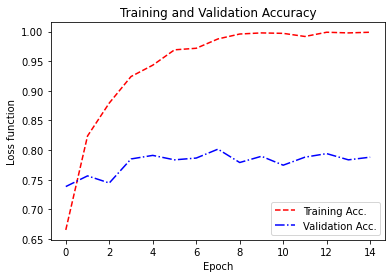

Test Accuracy : 0.7965116279069767


<Figure size 432x288 with 0 Axes>

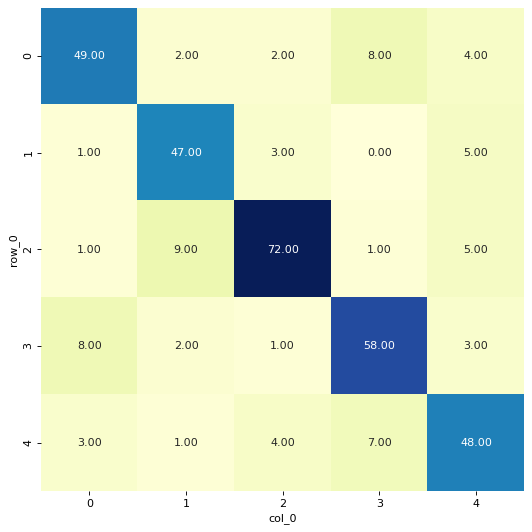

Epoch 1/15
134/134 [==============================] - 64s 474ms/step - loss: 0.8473 - accuracy: 0.6911 - val_loss: 0.7412 - val_accuracy: 0.7128
Epoch 2/15
134/134 [==============================] - 63s 474ms/step - loss: 0.4434 - accuracy: 0.8516 - val_loss: 0.6340 - val_accuracy: 0.7729
Epoch 3/15
134/134 [==============================] - 64s 480ms/step - loss: 0.2964 - accuracy: 0.8925 - val_loss: 0.6359 - val_accuracy: 0.7774
Epoch 4/15
134/134 [==============================] - 63s 473ms/step - loss: 0.2099 - accuracy: 0.9297 - val_loss: 0.7023 - val_accuracy: 0.7729
Epoch 5/15
134/134 [==============================] - 64s 481ms/step - loss: 0.1670 - accuracy: 0.9489 - val_loss: 0.6761 - val_accuracy: 0.7925
Epoch 6/15
134/134 [==============================] - 64s 476ms/step - loss: 0.0892 - accuracy: 0.9756 - val_loss: 0.7572 - val_accuracy: 0.7835
Epoch 7/15
134/134 [==============================] - 65s 483ms/step - loss: 0.0674 - accuracy: 0.9861 - val_loss: 0.7283 - val_ac

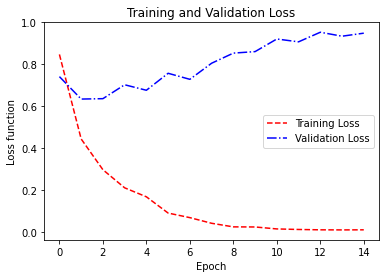

<Figure size 432x288 with 0 Axes>

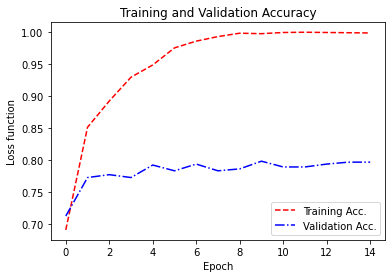

Test Accuracy : 0.7906976744186046


<Figure size 432x288 with 0 Axes>

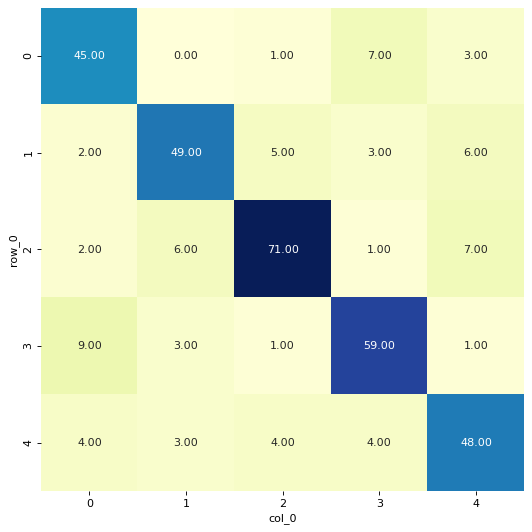

In [16]:



ModelNamesLs=["vgg16","vgg16"]#["vgg16","vgg16"]#,"vgg19"]
FineTune=[None,1]#,2]#[False,True]
ModelsLs=[]
for iGal, Gal in enumerate([GalleryPretrained]):
    for iMo,Mo in enumerate(ModelNamesLs):
        ModObj=PreatrainedModelz(Gal,Mo,batchsize=20,epochs=15,FineTune=FineTune[iMo])
        func="makebase_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs.append(ModObj)
        getattr(ModObj,func)()
        ModObj.configure_finetune()
        ModObj.add_final_layers()
        ModObj.compile_model()
        ModObj.train_model()
        ModObj.plot_history()
        #ModObj.
        #ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Gal.Test.ILabelFullLs,axis=-1))

There was no clear difference between training zero and one layers, but in any case, the application of the pre-trained model outperformed the models with fewer layers introduced earlier. The pre-trained models achieved test accuracy values in the order of 0.8, outmatching the few-layer models even with the overfitting reduction techniques. We can observe that the confusion matrix is strictly diagonally dominant, meaning that each diagonal element exceeds the sum of both its row or its column in absolute value. 

Next, we generated a model allowing relearning in two of the convolutional layers.

Epoch 1/15
134/134 [==============================] - 68s 506ms/step - loss: 0.8342 - accuracy: 0.7009 - val_loss: 0.6528 - val_accuracy: 0.7594
Epoch 2/15
134/134 [==============================] - 67s 501ms/step - loss: 0.4112 - accuracy: 0.8610 - val_loss: 0.4774 - val_accuracy: 0.8286
Epoch 3/15
134/134 [==============================] - 67s 498ms/step - loss: 0.2625 - accuracy: 0.9102 - val_loss: 0.5710 - val_accuracy: 0.8105
Epoch 4/15
134/134 [==============================] - 67s 501ms/step - loss: 0.1596 - accuracy: 0.9440 - val_loss: 0.6765 - val_accuracy: 0.8286
Epoch 5/15
134/134 [==============================] - 67s 498ms/step - loss: 0.1147 - accuracy: 0.9624 - val_loss: 0.7386 - val_accuracy: 0.8241
Epoch 6/15
134/134 [==============================] - 67s 497ms/step - loss: 0.0791 - accuracy: 0.9699 - val_loss: 0.8293 - val_accuracy: 0.7925
Epoch 7/15
134/134 [==============================] - 67s 500ms/step - loss: 0.0606 - accuracy: 0.9782 - val_loss: 0.8527 - val_ac

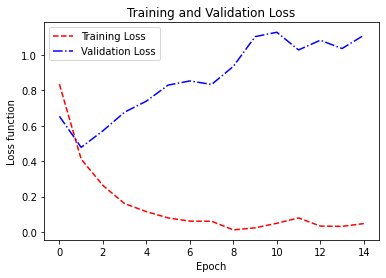

<Figure size 432x288 with 0 Axes>

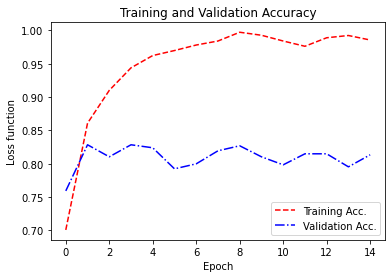

Test Accuracy : 0.8343023255813954


<Figure size 432x288 with 0 Axes>

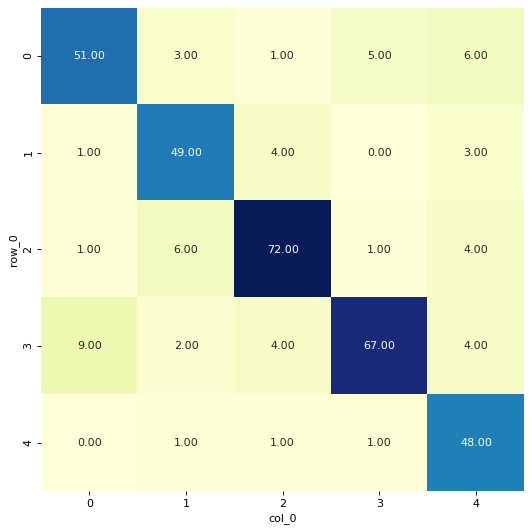

In [17]:
#myVGG16=PretrainedModelazos(Gal,modelname,batchsize=20,epochs=15)

ModelNamesLs=["vgg16"]#["vgg16","vgg16"]#,"vgg19"]
FineTune=[2]#,2]#[False,True]
ModelsLs=[]
for iGal, Gal in enumerate([GalleryPretrained]):
    for iMo,Mo in enumerate(ModelNamesLs):
        ModObj=PreatrainedModelz(Gal,Mo,batchsize=20,epochs=15,FineTune=FineTune[iMo])
        func="makebase_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs.append(ModObj)
        getattr(ModObj,func)()
        ModObj.configure_finetune()
        ModObj.add_final_layers()
        ModObj.compile_model()
        ModObj.train_model()
        ModObj.plot_history()
        #ModObj.
        #ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Gal.Test.ILabelFullLs,axis=-1))

The classifier with two retrained layers generated the highest test accuracy in the present study, with 0.83.

In all cases the overfitting phenomenon was present, although the difference between the accuracy values was generally narrower in the pre-trained models due to the test accuracy increasing from 0.6 to 0.83.

The benefits of using transfer learning are evident.